In [1]:
#run this to install the package
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [2]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

## **From Sheet to DataFrame to Regression Object**

In [3]:
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

In [4]:
x = read_sheets(US_Data,sheet='Food Expenditures 2021')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

### Filter Data Down

In [5]:
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)

Shape of y_sample: (22436,)
Shape of d_sample: (1750, 3)


## **Build Price Data**

In [6]:
#Add price data
p = pd.read_csv("proj3_min_cost_data - prices.csv")

# Change column names to actual unit values
p["u"] = "Kg"

p["m"] = "USA"

# Adjust price to per Kg from per g
p["price"] = p["price"] * 10

# Filter for only 2017/2018 prices
p = p[p["t"] == "2017/2018"]

# Change price data from 2017/2018 to 2021 using avg US CPIs in 2017/2018 and 2021
cpi_2021 = 271.0
cpi_2018 = 250.0
p["price"] = p["price"] * (cpi_2021/cpi_2018)

p["t"] = "2021"


codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j")
p_with_j = p # use later on for nutrition data
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})

# Now prices
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')
# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T

In [7]:
p_with_j

,t,j,m,price,u,parent_desc
10577,2021,11100000.0,USA,1.089247,Kg,"Milk, NFS"
10578,2021,11111000.0,USA,1.065355,Kg,"Milk, whole"
10579,2021,11112110.0,USA,0.998201,Kg,"Milk, reduced fat (2%)"
10580,2021,11112210.0,USA,0.985508,Kg,"Milk, low fat (1%)"
10581,2021,11113000.0,USA,1.002060,Kg,"Milk, fat free (skim)"
...,...,...,...,...,...,...
15007,2021,95320200.0,USA,1.311185,Kg,Sports drink (Gatorade G)
15008,2021,95320500.0,USA,0.996651,Kg,Sports drink (Powerade)
15009,2021,95322200.0,USA,1.236671,Kg,"Sports drink, low calorie (Gatorade G2)"
15010,2021,95322500.0,USA,0.964782,Kg,"Sports drink, low calorie (Powerade Zero)"


## **Run Regression**

In [8]:
from cfe import Regression

# Run the regression
result = Regression(y=y_filtered, d=d_sample, compute_se=False, rectify=False, min_obs=10, min_prop_items=0.002)

In [9]:
predicted = result.predicted_expenditures()
predicted.head()

i       t     m    j                               
130390  2021  USA  Apple, raw                          153.664292
                   Banana, raw                         108.128735
                   Butter, stick                         8.217772
                   Cheese, nfs                          19.828239
                   Coffee creamer, liquid, flavored     31.340555
dtype: float64

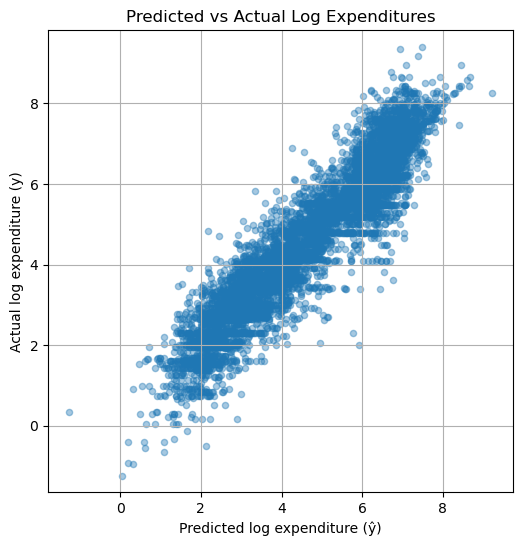

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y_sample,
    'yhat': result.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()

Can't compute covariance matrix; too few Hot pepper sauce.
Can't compute covariance matrix; too few Coffee creamer, liquid, flavored.


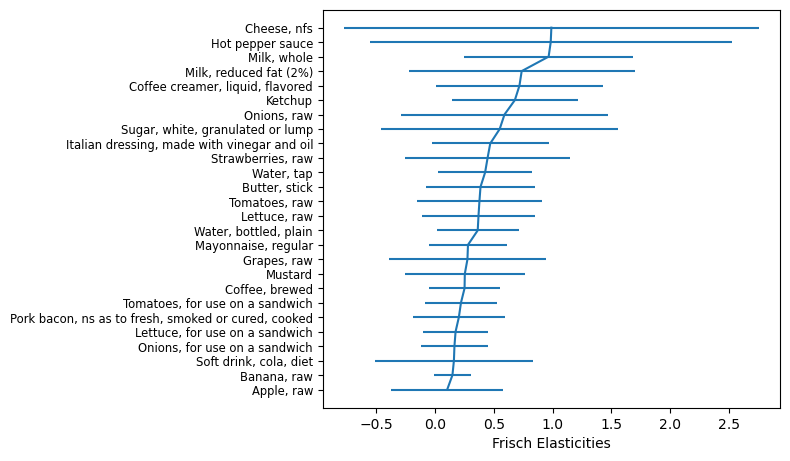

In [11]:
ax = result.graph_beta()

In [12]:
foods_in_regression = result.beta.index.get_level_values('j').unique()

In [13]:
result.get_beta().shape

(26,)

In [14]:
result.get_gamma().head()

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.002788,-0.042821,-0.030882,5.036137
"Banana, raw",0.000453,-0.119854,-0.016291,4.714381
"Butter, stick",0.002774,-0.121417,-0.274499,2.097622
"Cheese, nfs",-0.003574,-0.095129,-0.015629,2.946690
"Coffee creamer, liquid, flavored",-0.009049,-0.133970,-0.215899,3.424015


<Axes: ylabel='Density'>

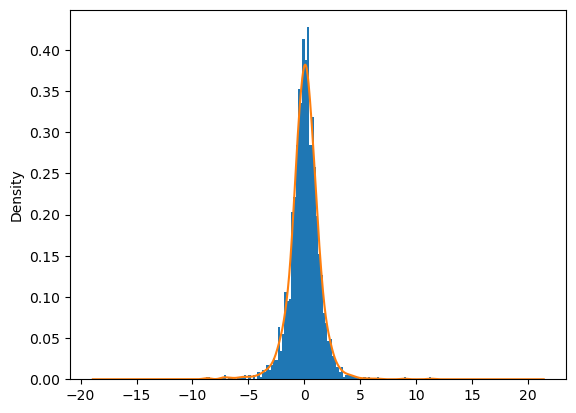

In [15]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [16]:
gamma = result.get_gamma()
gamma

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.002788,-0.042821,-0.030882,5.036137
"Banana, raw",0.000453,-0.119854,-0.016291,4.714381
"Butter, stick",0.002774,-0.121417,-0.274499,2.097622
"Cheese, nfs",-0.003574,-0.095129,-0.015629,2.946690
"Coffee creamer, liquid, flavored",-0.009049,-0.133970,-0.215899,3.424015
"Coffee, brewed",0.004524,-0.268188,-0.043867,5.898638
"Grapes, raw",0.000039,-0.033684,-0.172434,4.360065
Hot pepper sauce,0.000732,-0.189427,0.137956,2.174688
"Italian dressing, made with vinegar and oil",-0.004716,-0.229501,-0.124701,3.189602


## Saving Regression

In [17]:
result.to_pickle('us_estimates_2021.rgsn')

In [18]:
import cfe

# Load the result back into memory
result = cfe.regression.read_pickle('us_estimates_2021.rgsn')

## **Demand and Utility**

Having estimated the demand system, we can examine the implied demand curves.

## Budgets
Get food budget for all households, then find median budget:

In [19]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

**Reference Prices**
  
Choose reference prices. Here we’ll choose a particular year, and average prices across markets. If you wanted to focus on particular market you’d do this differently.

In [20]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)

# Instead of directly indexing with result.beta.index (which fails for missing keys),
# reindex pbar to have the same index as result.beta and fill missing prices with 1.
pbar = pbar.reindex(result.beta.index, fill_value=1)

# (Optional) Get the common keys, which should be all keys in result.beta.index:
common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]

# Replace any remaining missing values with 1.
pbar = pbar.replace(np.nan, 1)

# Finally, define a function to change the price of a single good in the price vector.
def my_prices(p0, j, p=pbar):
    """
    Change price of the jth good to p0, holding all other prices fixed.
    
    Parameters:
      p0 : float
          New price for the jth good.
      j : label
          Identifier for the good (must be present in p).
      p : pd.Series
          Price vector (default is pbar).
    
    Returns:
      pd.Series : A new price vector with the updated value.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

Index(['Apple, raw', 'Banana, raw', 'Butter, stick', 'Cheese, nfs',
       'Coffee creamer, liquid, flavored', 'Coffee, brewed', 'Grapes, raw',
       'Hot pepper sauce', 'Italian dressing, made with vinegar and oil',
       'Ketchup', 'Lettuce, for use on a sandwich', 'Lettuce, raw',
       'Mayonnaise, regular', 'Milk, reduced fat (2%)', 'Milk, whole',
       'Mustard', 'Onions, for use on a sandwich', 'Onions, raw',
       'Pork bacon, ns as to fresh, smoked or cured, cooked',
       'Soft drink, cola, diet', 'Strawberries, raw',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Water, bottled, plain', 'Water, tap'],
      dtype='object', name='j')

## **Demand Curve for One Food**

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

def plot_demand_curve(good):
    """
    Plot the demand curve for a given good over a range of price scales.
    
    Parameters
    ----------
    good : str
        The common key (food identifier) for which you want the demand curve,
        e.g. "Banana, raw".
        
    Global Variables (should be defined before calling this function):
      pbar         : pd.Series of reference prices (indexed by food identifier)
      result       : an object with a demands() method and attribute beta.index.
      xref         : reference expenditure vector (e.g., median household expenditures)
      xbar         : household total expenditures used to compute quantiles.
      my_prices()  : function that returns a modified price vector.
    """
    # Suppress warnings about negative beta values
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Reindex pbar so that it has the same index as result.beta.index, filling missing keys with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors: vary prices from 50% to 200% of the reference price.
    scale = np.linspace(0.5, 2, 20)
    
    # Compute demand for the given good at different price levels.
    # Wrap the list comprehensions in a warnings.catch_warnings block to suppress any warnings during computation.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
        median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                         for s in scale]
        demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
        demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
    
    # Create the plot.
    plt.figure(figsize=(8, 6))
    plt.plot(median_demand, scale, marker="o", label="Median Budget")
    plt.plot(demand_q25, scale, marker="s", label="25th Percentile Budget")
    plt.plot(demand_q75, scale, marker="^", label="75th Percentile Budget")
    
    # Add axis labels, title, legend, and grid.
    plt.xlabel(f"Quantities of {good} Demanded")
    plt.ylabel(f"Price (relative to base of {pbar_local[good]:.2f})")
    plt.title(f"Demand Curve for {good}")
    plt.legend()
    plt.grid(True)
    plt.show()

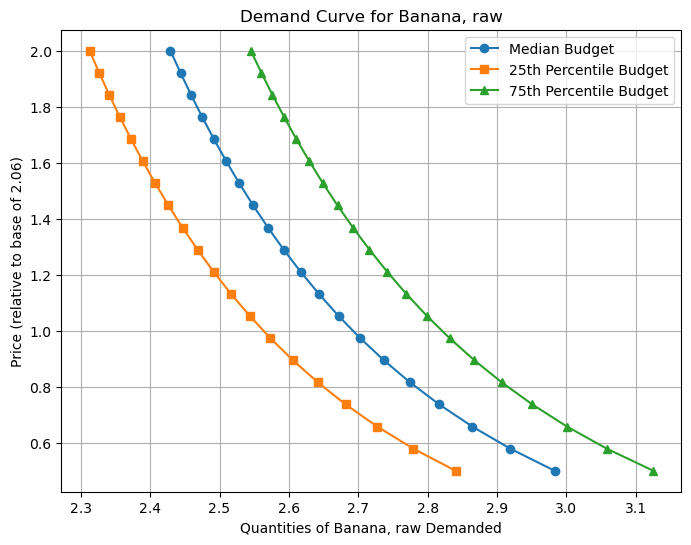

In [22]:
plot_demand_curve('Banana, raw')

## **Demand Curve for More than One good**

In [23]:
def plot_demand_curves(goods):
    """
    Plot demand curves for multiple goods over a range of price scales.
    
    Parameters
    ----------
    goods : tuple or list of str
        The food identifiers (common keys) for which you want to plot demand curves.
        For example: ('Banana, raw', 'Apple, raw', 'Milk, whole')
    
    Global variables required:
      - pbar: pd.Series with reference prices (indexed by food identifiers)
      - result: an object with methods demands() and attribute beta.index
      - xref: reference expenditure vector (e.g., median expenditures)
      - xbar: household total expenditures (used for quantile calculations)
      - my_prices(): function to adjust the price vector
    """
    # Suppress specific warnings (from consumerdemands._utils)
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Ensure pbar covers all keys in result.beta.index; fill missing values with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors to vary the price from 50% to 200% of reference.
    scale = np.linspace(0.5, 2, 20)
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 8))
    
    # Loop over each good in the input tuple/list.
    for good in goods:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
            # Compute the demand for the given good at various price levels.
            median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                             for s in scale]
            demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
            demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
        
        # Plot each demand curve with distinct line styles and markers.
        plt.plot(median_demand, scale,
                 label=f"{good} (Median Budget)")
        plt.plot(demand_q25, scale,
                 label=f"{good} (25th Percentile Budget)")
        plt.plot(demand_q75, scale,
                 label=f"{good} (75th Percentile Budget)")
    
    # Add labels, title, legend, and grid.
    plt.xlabel("Quantity Demanded")
    # This label uses the base reference price of the first good in the list for display.
    plt.ylabel(f"Price (relative to base of {pbar_local[goods[0]]:.2f})")
    plt.title("Demand Curves for Selected Goods")
    plt.legend()
    plt.grid(True)
    plt.show()

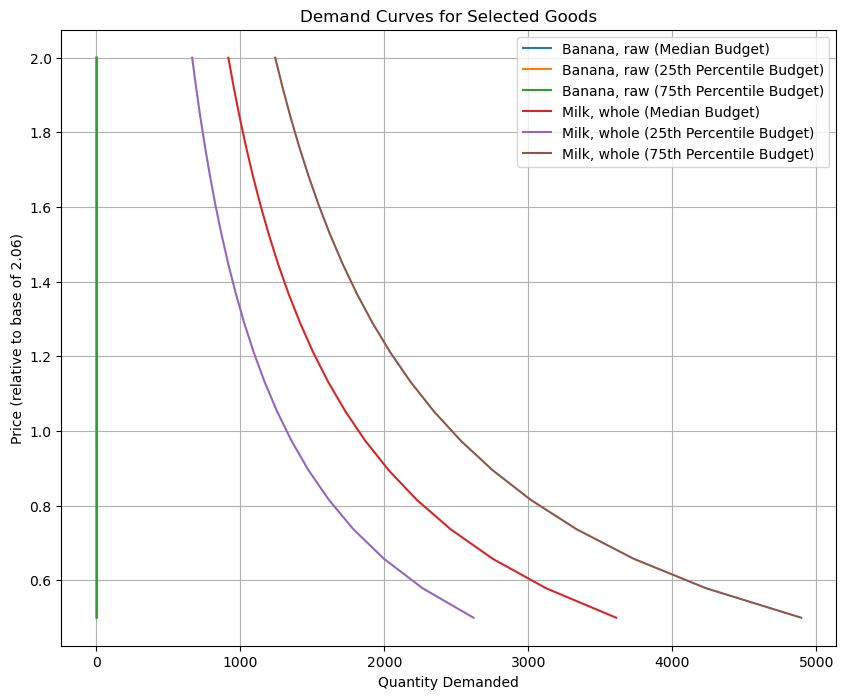

In [24]:
# Example usage:
plot_demand_curves(('Banana, raw', 'Milk, whole'))

## **Engle Curves**

NameError: name 'scale' is not defined

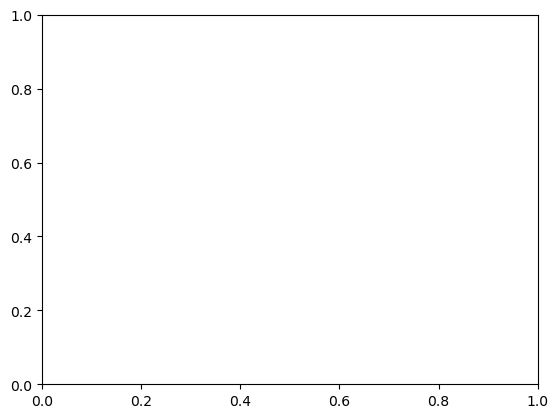

In [25]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

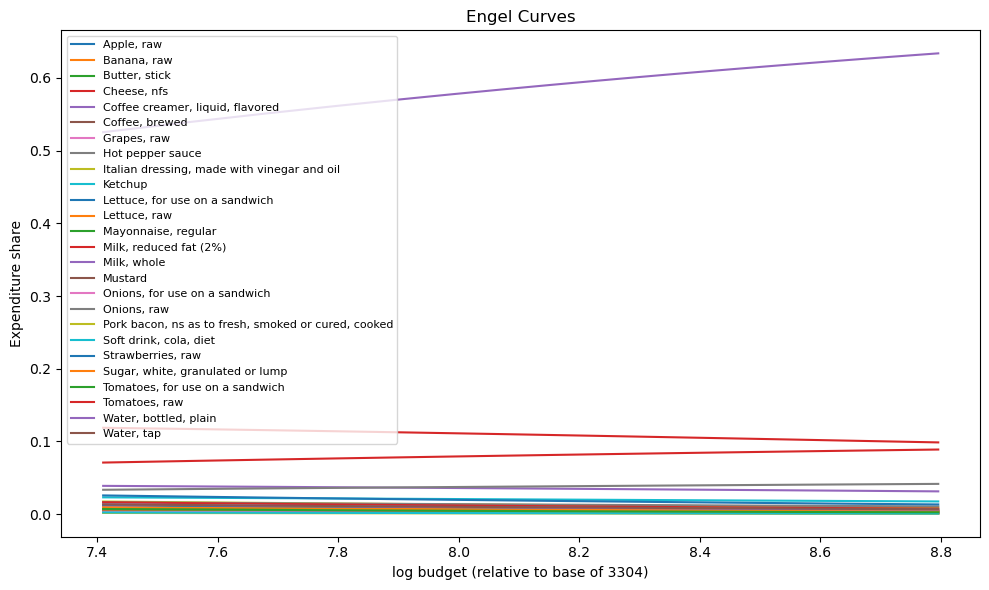

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create a range of budgets by scaling the base budget xref.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar.
for good in pbar.index:
    shares = []
    for s in scale:
        budget = s * xref  # Adjust budget by the scale factor.
        # Compute expenditures for all goods at this budget.
        exp_series = result.expenditures(budget, pbar)
        # Compute the expenditure share for the current good.
        share = exp_series[good] / budget
        shares.append(share)
    # Plot the Engel curve for the current good,
    # using the log-budget (log(scale * xref)) on the x-axis.
    ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves')

# Add a legend to label each curve with the good’s name.
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

## **Indirect Utility**

Text(0.5, 1.0, 'Indirect Utility Function')

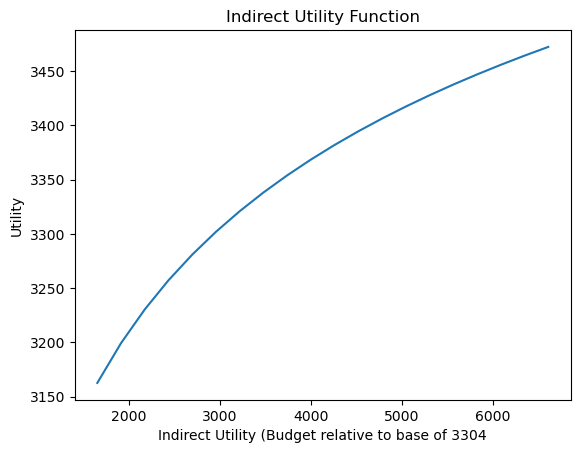

In [27]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# **[A] Nutritional Data**
### Step 1: Acquire DataFrames

In [28]:
# Helper function
def format_id(id, zeropadding=0):
    if pd.isnull(id) or id in ['', '.']:
        return None
    try:
        return ('%d' % id).zfill(zeropadding)
    except TypeError:
        return id.split('.')[0].strip().zfill(zeropadding)
    except ValueError:
        return None

data_url = "https://docs.google.com/spreadsheets/d/1l0Xl1NwSRN0dPwjHRWDEnChBWqTx7VPXOnLnJKI2lAY/edit?gid=415594035#gid=415594035"

# Load nutrition data and merge
nutrition = read_sheets(data_url, sheet="nutrients") \
            .assign(ingred_code=lambda df: df["ingred_code"].apply(format_id))

In [29]:
# Load the original recipes data from the specified Google Sheet (sheet named "recipes")
og_recipes = read_sheets(data_url, sheet="recipes")

# Clean and transform the data:
# - Apply the format_id function to 'parent_foodcode' and 'ingred_code' columns to standardize their format
# - Rename the 'parent_desc' column to 'recipe' for better clarity
og_recipes = (og_recipes
              .assign(
                  parent_foodcode=lambda df: df["parent_foodcode"].apply(format_id),
                  ingred_code=lambda df: df["ingred_code"].apply(format_id)
              )
              .rename(columns={"parent_desc": "recipe"}))

In [88]:
# Make an explicit copy of recipes before modifying
recipes = og_recipes.copy()

# Normalize ingredient weights to percentages by dividing by the total weight per meal.
# Using .loc for assignment ensures we're modifying the DataFrame in place.
recipes.loc[:, 'ingred_wt'] = recipes['ingred_wt'] / recipes.groupby('parent_foodcode')['ingred_wt'].transform("sum")

# Merge nutrient information into recipes on the 'ingred_code' column.
# This performs a left join, ensuring all recipes are kept.
df = recipes.merge(nutrition, how="left", on="ingred_code")

# Identify numeric columns (e.g., nutrient values) in the merged DataFrame.
numeric_cols = list(df.select_dtypes(include=["number"]).columns)

# Remove 'ingred_wt' from the list as we don't want to scale it.
numeric_cols.remove("ingred_wt")

# Multiply each nutrient value by the normalized ingredient weight to get weighted nutrient values.
df[numeric_cols] = df[numeric_cols].mul(df["ingred_wt"], axis=0)

# Aggregate nutrient profiles by meal (identified by 'parent_foodcode').
# For nutrient columns, sum their weighted values; for the recipe name, take the first occurrence.
df = df.groupby('parent_foodcode').agg({
    **{col: "sum" for col in numeric_cols},
    "recipe": "first"
})

# Rename the index to 'recipe_id' for clarity.
df.index.name = "recipe_id"

# Extract recipe names for further use.
food_names = df["recipe"]
FCT = df.reset_index()
FCT.rename(columns={'recipe_id': 'j'}, inplace=True)
FCT

,j,Capric acid,Lauric acid,Myristic acid,Palmitic acid,Palmitoleic acid,Stearic acid,Oleic acid,Linoleic Acid,Linolenic Acid,...,"Vitamin B-12, added",Vitamin B6,Vitamin C,Vitamin D,Vitamin E,"Vitamin E, added",Vitamin K,Water,Zinc,recipe
0,11000000,0.06300,0.2560,0.32100,0.91900,0.12900,0.29300,1.4750,0.37400,0.05200,...,0.0,0.01100,5.000,0.100,0.0800,0.0,0.300,87.5000,0.1700,"Milk, human"
1,11100000,0.03825,0.0405,0.14275,0.42475,0.01175,0.18575,0.3970,0.05350,0.02200,...,0.0,0.03700,0.050,1.225,0.0300,0.0,0.150,89.5250,0.4225,"Milk, NFS"
2,11111000,0.07500,0.0770,0.29700,0.82900,0.00000,0.36500,0.8120,0.12000,0.07500,...,0.0,0.03600,0.000,1.300,0.0700,0.0,0.300,88.1300,0.3700,"Milk, whole"
3,11111100,0.08700,0.0970,0.34800,0.91000,0.07700,0.41900,0.8700,0.07800,0.05000,...,0.0,0.03400,0.900,1.300,0.0800,0.0,0.300,88.2000,0.3800,"Milk, low sodium, whole"
4,11111150,0.07500,0.0770,0.29700,0.82900,0.00000,0.36500,0.8120,0.12000,0.07500,...,0.0,0.03600,0.000,1.300,0.0700,0.0,0.300,88.1300,0.3700,"Milk, calcium fortified, whole"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8883,99997802,0.00000,0.0000,0.00040,0.02290,0.00085,0.00760,0.0272,0.07200,0.00335,...,0.0,0.09120,16.405,0.000,0.4795,0.0,7.125,93.9475,0.1680,Tomatoes as ingredient in omelet
8884,99997804,0.00000,0.0000,0.00040,0.03990,0.00000,0.00930,0.0017,0.14000,0.00080,...,0.0,0.11160,6.545,0.170,0.0290,0.0,0.410,92.1880,0.4655,Other vegetables as ingredient in omelet
8885,99997810,0.00205,0.0010,0.00125,0.03660,0.00090,0.00560,0.0139,0.04925,0.01145,...,0.0,0.17585,16.840,0.000,0.2105,0.0,8.375,86.4005,0.2610,Vegetables as ingredient in curry
8886,99998130,0.00050,0.0002,0.01690,2.39040,0.02780,0.93590,5.0233,11.80350,1.67480,...,0.0,0.10420,2.490,0.060,1.8960,0.0,50.840,55.9730,0.2110,Sauce as ingredient in hamburgers


In [121]:
df_clean = p_with_j.drop(columns=["u"])

# Use pivot_table instead of pivot so that duplicate combinations are aggregated.
# Here we take the median price if there are duplicates.
df_pivot = df_clean.pivot_table(
    index=["t", "m"],
    columns="parent_desc",
    values="price",
    aggfunc="median"
)

# Optionally, reset the index if you prefer 't' and 'm' to be columns.
df_pivot = df_pivot.reset_index()
df_pivot

parent_desc,t,m,100 GRAND Bar,3 MUSKETEERS Bar,"Adobo, with noodles","Adobo, with rice",Agave liquid sweetener,"Alcoholic malt beverage, sweetened","Alfalfa sprouts, raw",Alfredo sauce,...,"Yogurt, low fat milk, plain","Yogurt, nonfat milk, flavors other than fruit","Yogurt, nonfat milk, fruit","Yogurt, nonfat milk, plain","Yogurt, soy","Yogurt, whole milk, baby food","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain","Zucchini soup, cream of, prepared with milk"
0,2021,USA,11.070784,13.636395,7.314843,6.921687,9.241013,4.083005,17.574317,5.459241,...,4.468226,5.731379,4.718012,4.468226,9.966253,6.452141,5.731379,4.718012,4.468226,2.652385


In [115]:
wweia = read_sheets(US_Data, sheet="Household Characteristics 2021")

# --- Ensure Age is Numeric ---
wweia["age"] = pd.to_numeric(wweia["age"], errors="coerce")

# --- Create Age Bins ---
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]
wweia["age_range"] = pd.cut(wweia["age"], bins=bins, labels=labels, right=False)

# --- Create Combined Age-Sex Category ---
# This concatenates the age range and sex (e.g. "10-19" and "Female" becomes "10-19_Female").
wweia["age_sex"] = wweia["age_range"].astype(str) + "_" + wweia["sex"]

# --- Generate Dummy Variables for Combined Age-Sex ---
dummy_age_sex = pd.get_dummies(wweia["age_sex"])
# Convert any Boolean values to integers (0s and 1s).
dummy_age_sex = dummy_age_sex.astype(int)

# Now, rename the dummy columns to swap the order and replace hyphens with underscores.
new_columns = {}
for col in dummy_age_sex.columns:
    # Expected format: "0-9_Female" or similar.
    parts = col.split("_")
    if len(parts) == 2:
        age_range, sex = parts
        # Replace hyphen in age_range with underscore.
        age_range_clean = age_range.replace("-", "_")
        new_columns[col] = f"{sex}_{age_range_clean}"
    else:
        new_columns[col] = col

dummy_age_sex = dummy_age_sex.rename(columns=new_columns)

# --- Concatenate Dummy Variables with Original Data ---
wweia_with_dummies = pd.concat([wweia, dummy_age_sex], axis=1)

# --- Drop the Intermediate Columns ---
wweia_with_dummies = wweia_with_dummies.drop(columns=["age_range", "age_sex"])
wweia_with_dummies.head()

,i,t,m,age,sex,HH_size,Female_0_9,Male_0_9,Female_10_19,Male_10_19,...,Female_40_49,Male_40_49,Female_50_59,Male_50_59,Female_60_69,Male_60_69,Female_70_79,Male_70_79,Female_80_89,Male_80_89
0,130378,2021,USA,43.0,Male,4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,130379,2021,USA,66.0,Male,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,130380,2021,USA,44.0,Female,7,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,130381,2021,USA,5.0,Female,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,130382,2021,USA,2.0,Male,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
sheet_id = '1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU'

# Suppose you have four DataFrames already built:
# wweia_with_dummies, p_with_j, FCT, etc.
# We'll pass those directly in the dictionary.
InputFiles = {
    'Expenditures_2021': (sheet_id, 'Food Expenditures 2021'),   # Google Sheet
    'HH_Characteristics': (wweia_with_dummies, 'Household Characteristics 2021'),  # In-memory DF
    'Prices': (df_pivot, 'Prices 2021'),   # In-memory DF
    'FCT': (FCT, 'nutrients'),             # In-memory DF
    'RDI': ('12Z4n8HbFZRYvH6B-D8EDLDibRiL50zNMlSBLMJ41C1o', 'rda')  # Google Sheet
}

In [117]:
###############################################################################
# 1. Define a Flexible "get_clean_sheet" Function
###############################################################################
def get_clean_sheet(key, sheet=None):
    """
    If key is a DataFrame, simply return a cleaned copy.
    If key is a string, assume it is a Google Sheet id (or URL) and read it.
    
    Parameters:
        key (str or DataFrame): Sheet ID/URL or an already loaded DataFrame.
        sheet (str): The sheet/tab to read (used only if key is a string).
    
    Returns:
        df (DataFrame): The cleaned DataFrame.
    """
    if isinstance(key, pd.DataFrame):
        # It's already a DataFrame, so just make a copy
        df = key.copy()
    else:
        # Otherwise, assume key is a Google Sheet ID
        df = read_sheets(key, sheet=sheet)
    
    # Clean up columns: strip whitespace, remove duplicates, drop "Unnamed"
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    
    # Remove duplicate index entries if any
    df = df.loc[~df.index.duplicated(), :]
    
    return df

###############################################################################
# 2. Read/Clean the Expenditures Data
###############################################################################
x = get_clean_sheet(
    InputFiles['Expenditures_2021'][0],
    sheet=InputFiles['Expenditures_2021'][1]
)
# Provide a default "m" column if missing
if 'm' not in x.columns:
    x['m'] = 1

# Now set a multi-index if the columns 'i','t','m' exist
for c in ['i','t','m']:
    if c not in x.columns:
        raise KeyError(f"Column '{c}' not found in Expenditures data.")
x = x.set_index(['i','t','m'])
x.columns.name = 'j'
x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
x = x.replace(0, np.nan)

###############################################################################
# 3. Read/Clean the Household Characteristics Data
###############################################################################
z = get_clean_sheet(
    InputFiles['HH_Characteristics'][0],
    sheet=InputFiles['HH_Characteristics'][1]
)
if 'm' not in z.columns:
    z['m'] = 1

for c in ['i','t','m']:
    if c not in z.columns:
        raise KeyError(f"Column '{c}' not found in HH_Characteristics data.")
z = z.set_index(['i','t','m'])
z.columns.name = 'k'
z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))

###############################################################################
# 4. Read/Clean the Prices Data
###############################################################################
p = get_clean_sheet(
    InputFiles['Prices'][0],
    sheet=InputFiles['Prices'][1]
)
if 'm' not in p.columns:
    p['m'] = 1

for c in ['t','m','j']:
    if c not in p.columns:
        # If 'j' is in columns or is the row index? Adjust if needed.
        raise KeyError(f"Column '{c}' not found in Prices data.")

# If you want (t,m) as the index and j as a column name, do:
p = p.set_index(['t','m'])
p.columns.name = 'j'
p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
p = p.replace(0, np.nan)

###############################################################################
# 5. Read/Clean the FCT
###############################################################################
fct = get_clean_sheet(
    InputFiles['FCT'][0],
    sheet=InputFiles['FCT'][1]
)
# If this is an in-memory DF, columns might differ. Suppose we want 'j' as the index
if 'j' not in fct.columns:
    raise KeyError("Column 'j' not found in FCT data.")
fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))

###############################################################################
# 6. Read/Clean the RDI
###############################################################################
rdi = get_clean_sheet(
    InputFiles['RDI'][0],
    sheet=InputFiles['RDI'][1]
)
# Suppose 'n' is the index of the RDI table
if 'Nutrient' not in rdi.columns:
    raise KeyError("Column 'n' not found in RDI data.")
rdi = rdi.set_index('Nutrient')
rdi.columns.name = 'k'

###############################################################################
# 7. Example: Checking Overlaps
###############################################################################
common_foods = x.columns.intersection(fct.index)
print(f"Number of overlapping foods in expenditures and FCT: {len(common_foods)}")
print("Sample of overlapping goods:", list(common_foods)[:10])


KeyError: "Column 'j' not found in Prices data."

In [122]:
x

j                       j   grams  food_name
i      t    m                               
130378 2021 USA  13110102  125.00        NaN
            USA  14108010    2.08        NaN
            USA  24100000  170.10        NaN
            USA  24100020  170.10        NaN
            USA  26137123  170.10        NaN
...                   ...     ...        ...
142310 2021 USA  92101000  480.00        NaN
            USA  93301110  360.00        NaN
            USA  93401010    1.88        NaN
            USA  93505000   84.00        NaN
            USA  94100100  493.50        NaN

[141104 rows x 3 columns]